<a id="Intro"></a>
<div class="alert alert-block alert-info">
<b>Introduction</b>
</div>

This is my first kernel at Kaggle. I choosed the Titanic competition because it's a very good way to introduce feature engineering and classification models.

**objective** : Predict if a passenger can survived on the titanic or not.

![Titanic](https://pngimg.com/uploads/titanic/titanic_PNG6.png)

* **Content :**
1. [Introduction](#Intro)
2. [Importing Labreries](#ImportingLabreries)
3. [Loading the data](#LoadingData)
4. [Exploratory data Analysis](#EDA)
5. [Data Preprocessing](#Pre-Processing)
6. [Modling](#Modling)
7. [Submition](#Submition)

<a id="ImportingLabreries"></a>
<div class="alert alert-block alert-info">
<b>Importing Labreries</b>

In [1]:
import numpy as np 
import pandas as pd
import os

#Data Visualization:
import matplotlib.pyplot as plt
import seaborn as sns

#Text Color
from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

<a id="LoadingData"></a>
<div class="alert alert-block alert-info">
<b>Loading the data</b><center>

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test=pd.read_csv('/kaggle/input/titanic/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print('train : {} , test : {}'.format(colored(train.shape,'blue'),colored(test.shape,'blue')))

train : (891, 12) , test : (418, 11)


In [6]:
gender_submission=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<a id="EDA"></a>

<div class="alert alert-block alert-info">
<b>Exploratory data Analysis</b><center>

* **Surivors and gender :**

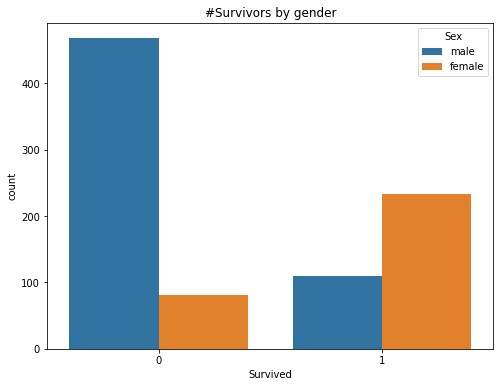

In [7]:
# #Survivors By gneder
sns.countplot(x='Survived',hue='Sex',data=train)
plt.title('#Survivors by gender')
plt.show()

**Women more likely to survive than men**

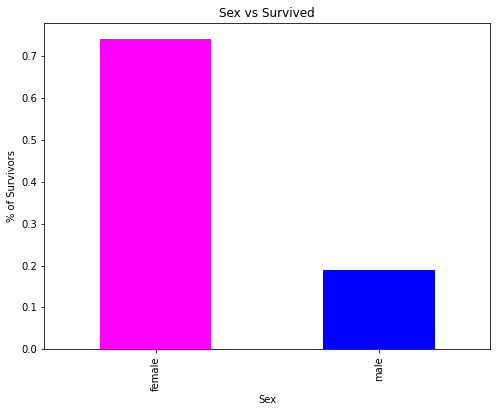

In [8]:
train.groupby(['Sex']).Survived.mean().plot.bar(color=['fuchsia', 'blue'])
plt.xlabel('Sex')
plt.ylabel('% of Survivors')
plt.title('Sex vs Survived')
plt.show()

**74% of female and 18% of male survived form the titanc.**

* **Passanger Age :**

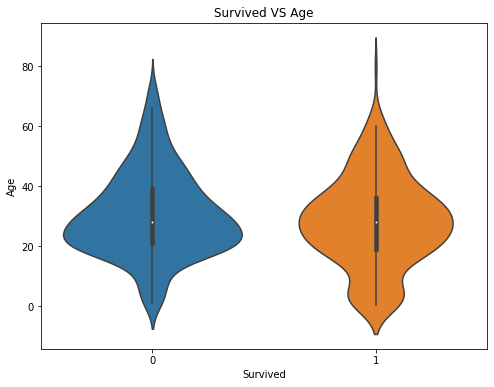

In [9]:
sns.violinplot(x='Survived',y='Age',data=train)
plt.title('Survived VS Age')
plt.show()

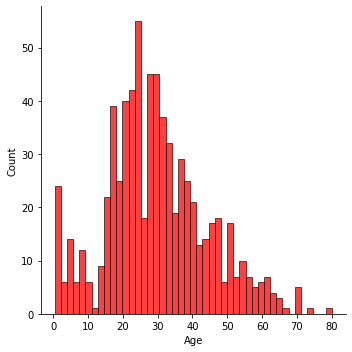

In [10]:
# Distribution of Age
sns.displot(x='Age',data=train,color='r',bins=45)
plt.show()

* **Passanger Class (Pclass) :**

In [11]:
train.groupby(['Pclass']).Survived.agg(['count','mean'])

,count,mean
Pclass,,
1,216,0.629630
2,184,0.472826
3,491,0.242363


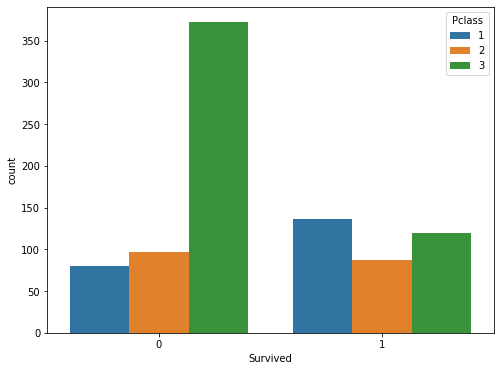

In [12]:
sns.countplot(x='Survived',hue='Pclass',data=train)
plt.show()

**62% of survivors are using the class 1**

Travling in a Higher class increase the probability of surviving

* **Port of Embarkation :**


*  C = Cherbourg
* Q = Queenstown 
* S = Southampton

In [13]:
train.Embarked.value_counts().to_frame()

,Embarked
S,644
C,168
Q,77


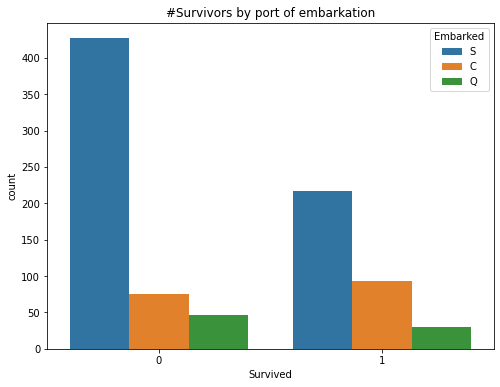

In [14]:
sns.countplot(x='Survived',hue='Embarked',data=train)
plt.title('#Survivors by port of embarkation')
plt.show()

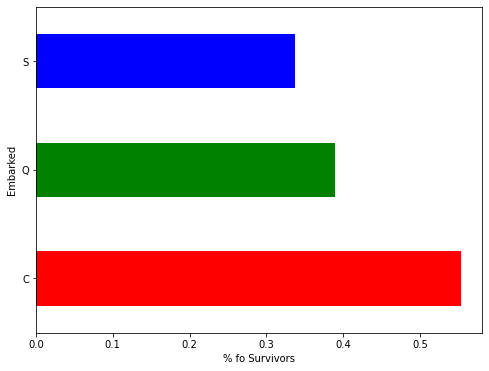

In [15]:
train.groupby(['Embarked']).Survived.mean().plot.barh(color=['Red','green','blue' ])
plt.xlabel('% fo Survivors')
plt.show()

* **Familly (SibSp and Parch):**

In [16]:
train.groupby(['SibSp']).Survived.agg(['count','mean'])

,count,mean
SibSp,,
0,608,0.345395
1,209,0.535885
2,28,0.464286
3,16,0.250000
4,18,0.166667
5,5,0.000000
8,7,0.000000


In [17]:
train.groupby(['Parch']).Survived.agg(['count','mean'])

,count,mean
Parch,,
0,678,0.343658
1,118,0.550847
2,80,0.500000
3,5,0.600000
4,4,0.000000
5,5,0.200000
6,1,0.000000


In [18]:
train.groupby(['SibSp','Parch']).Survived.agg(['count','mean'])

count      mean
SibSp Parch                 
0     0        537  0.303538
      1         38  0.657895
      2         29  0.724138
      3          1  1.000000
      4          1  0.000000
      5          2  0.000000
1     0        123  0.520325
      1         57  0.596491
      2         19  0.631579
      3          3  0.333333
      4          3  0.000000
      5          3  0.333333
      6          1  0.000000
2     0         16  0.250000
      1          7  0.857143
      2          4  0.500000
      3          1  1.000000
3     0          2  1.000000
      1          7  0.000000
      2          7  0.285714
4     1          9  0.000000
      2          9  0.333333
5     2          5  0.000000
8     2          7  0.000000

* **Passenger Fare :**

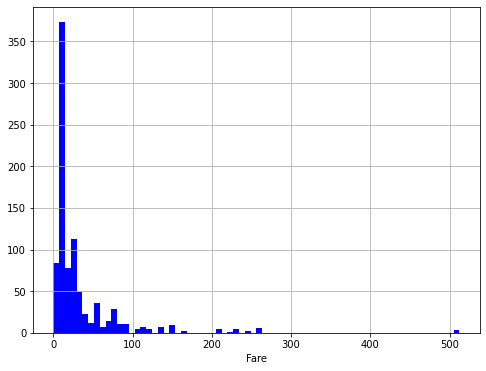

In [19]:
#Fare Distribution:

train.Fare.hist(bins=70,color='b')
plt.xlabel('Fare')
plt.show()

* **Conrdinality:**

In [20]:
for col in ['Name','Ticket','Cabin']:
    print('Conrdinality of {} is : {} '.format(colored(col,'green'),colored(len(train[col].unique()),'blue')))

Conrdinality of Name is : 891 
Conrdinality of Ticket is : 681 
Conrdinality of Cabin is : 148 


**We can see that the cordinality of Name,Ticket and Cabin is high**

* **Correlation**

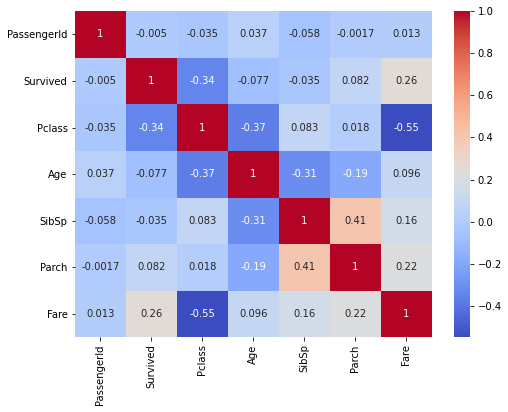

In [21]:
heatmap=sns.heatmap(train.corr(),annot=True,cmap='coolwarm')

In [22]:
train.corr()[['Survived']].T

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,-0.005007,1.0,-0.338481,-0.077221,-0.035322,0.081629,0.257307


Correlations between the target variable and numerical variables aren't high

<a id="Pre-Processing"></a>

<div class="alert alert-block alert-info">
<b>Data Pre-Processing</b><center>


Let's Combine train and test set for easy preprocessing

In [23]:
ntrain=train.shape[0] # will be used to split combined data set

data=pd.concat((train,test)).reset_index(drop=True)
print('The shape of the combined dataframe is:', colored(data.shape,'blue'))

The shape of the combined dataframe is: (1309, 12)


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [25]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Handling Missing values :

In [26]:
#Check for missing values :
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

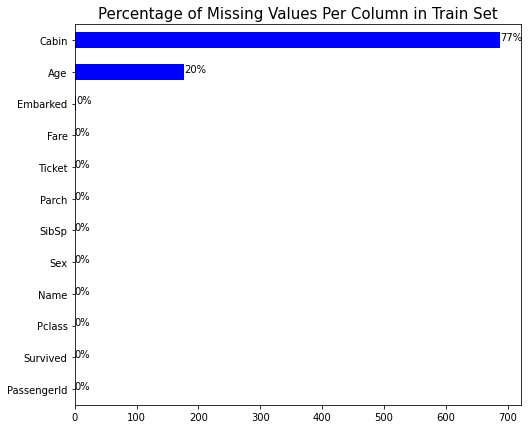

In [27]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (8, 7),color='b')
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [28]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

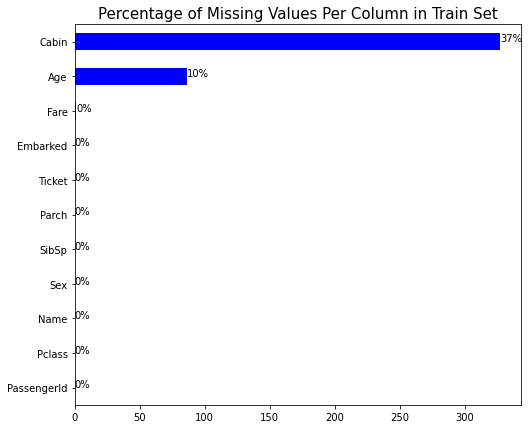

In [29]:
# Check if there any missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (8, 7),color='b')
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

***The Cabin column contains maximum null values in both datasets.***

*  **Fill in missing values :**

In [30]:
#lets save the location of Nan values first :
cabin_nan=np.where(data.Cabin.isnull(),1,0)
age_nan=np.where(data.Age.isnull(),1,0)

* For Embarked and Cabin variables. I choose to use the most popular value
* For Age and Fare I will use the mean value

In [31]:
data['Cabin']=data['Cabin'].fillna(data.Cabin.value_counts().index[0])
data['Embarked']=data['Embarked'].fillna(data.Embarked.value_counts().index[0])
data['Age']=data['Age'].fillna(data['Age'].mean())
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

### Feature Engineering

This two columns save the locations of NaN values in the two columns Cabin and Age

In [32]:
data['CabinNan']=cabin_nan
data['AgeNan']=age_nan

Here I will create a new feature where I will get first letter from every Cabin in the dataset.

In [33]:
data['cabinLetter']=data.Cabin.apply(lambda x:x[0])
data['cabinLetter'].value_counts()

C    1108
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabinLetter, dtype: int64

In [34]:
data['familySize']=data.SibSp+data.Parch+1

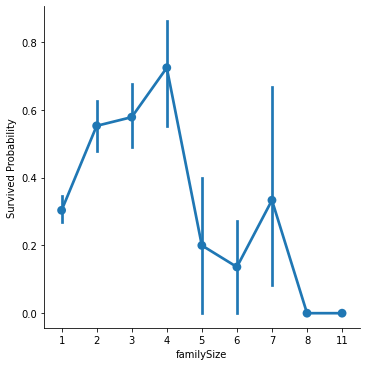

In [35]:
sns.factorplot(x="familySize",y="Survived",data = data).set_ylabels('Survived Probability')
plt.show()

In [36]:
data['Alone']=[1 if Fsize==1 else 0 for Fsize in data['familySize']]
data['withFamily']=[1 if Fsize>=2 else 0 for Fsize in  data['familySize']]

* Name :

In [37]:
data.Name.sample(10)

379                           Gustafsson, Mr. Karl Gideon
291               Bishop, Mrs. Dickinson H (Helen Walton)
1068                      Stengel, Mr. Charles Emil Henry
828                          McCormack, Mr. Thomas Joseph
956     Corey, Mrs. Percy C (Mary Phyllis Elizabeth Mi...
198                      Madigan, Miss. Margaret "Maggie"
566                                  Stoytcheff, Mr. Ilia
527                                    Farthing, Mr. John
1166                  Bryhl, Miss. Dagmar Jenny Ingeborg 
25      Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...
Name: Name, dtype: object

**Maybe We can extract Name title ;)**

For that we will use Regular Expressions, the title is always starting with one capital letter after that we have small letters and finaly there's end point.

In [38]:
import re
data["NameTitle"] = data.Name.apply(lambda x:re.search(' ([A-Z][a-z]+)\. ',x).group(1))

In [39]:
data.NameTitle.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Major         2
Mlle          2
Lady          1
Dona          1
Jonkheer      1
Don           1
Capt          1
Countess      1
Mme           1
Sir           1
Name: NameTitle, dtype: int64

In [40]:
data[data.NameTitle=='Dr'][['Sex','Age','NameTitle']]

,Sex,Age,NameTitle
245,male,44.000000,Dr
317,male,54.000000,Dr
398,male,23.000000,Dr
632,male,32.000000,Dr
660,male,50.000000,Dr
766,male,29.881138,Dr
796,female,49.000000,Dr
1184,male,53.000000,Dr


there just one female with Dr as a NameTitle and her age is 49. So we can change her title to Mrs

In [41]:
data.loc[[796],['NameTitle']]='Mrs' 
data.loc[[796]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNan,AgeNan,cabinLetter,familySize,Alone,withFamily,NameTitle
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,0,0,D,1,1,0,Mrs


In [42]:
#Col and Major:
data[(data.NameTitle=='Col')|(data.NameTitle=='Major')|(data.NameTitle=='Jonkheer')|(data.NameTitle=='Capt')][['Sex','NameTitle']]

,Sex,NameTitle
449,male,Major
536,male,Major
647,male,Col
694,male,Col
745,male,Capt
822,male,Jonkheer
1022,male,Col
1093,male,Col


All Majors, Colonels, Capt and Jonkheer are male gender so we can use Mr as a Name title

In [43]:
data[data['NameTitle']=='Ms']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNan,AgeNan,cabinLetter,familySize,Alone,withFamily,NameTitle
443,444,1.0,2,"Reynaldo, Ms. Encarnacion",female,28.000000,0,0,230434,13.00,C23 C25 C27,S,1,0,C,1,1,0,Ms
979,980,NaN,3,"O'Donoghue, Ms. Bridget",female,29.881138,0,0,364856,7.75,C23 C25 C27,Q,1,1,C,1,1,0,Ms


In [44]:
data['NameTitle']=data['NameTitle'].replace(['Lady','Mme','Dona','Countess'],'Mrs')
data['NameTitle']=data['NameTitle'].replace(['Mlle','Ms'],'Miss')
data['NameTitle']=data['NameTitle'].replace(['Rev','Dr','Major','Don','Capt','Col','Sir','Jonkheer'],'Mr')

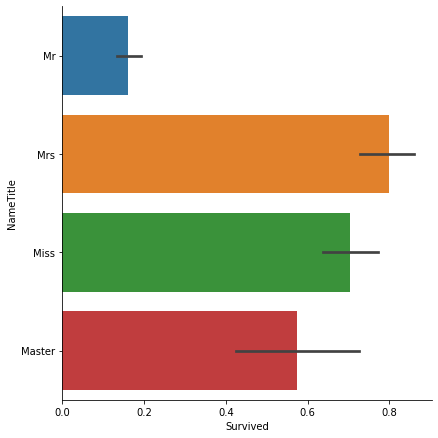

In [45]:
sns.factorplot(x="Survived", y ="NameTitle", data=data, kind="bar", size=6)
plt.show()

In [46]:
def Create_Cat(col,q):
    return pd.qcut(data['Age'],  q=q, labels=False)
    
data['Age_Cat']=Create_Cat('Age',4)
data['Fare_Cat']=Create_Cat('Fare',4)

###  Lable Encoding 

In [47]:
numericalFeatures = [feature for feature in data.columns if data[feature].dtypes!='O']
CategoricalFeatures=[feature for feature in data.columns if data[feature].dtype=='O']

In [48]:
from sklearn.preprocessing import LabelEncoder
for col in CategoricalFeatures:
    data[col]=LabelEncoder().fit_transform(data[col])

<a id="Modling"></a>

<div class="alert alert-block alert-info">
<b>Modling</b><center>


* **Split the data**:

In [49]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
data[['Age','Fare']]=sc.fit_transform(data[['Age','Fare']])

In [50]:
# Separate train and test data from the combined dataframe
train_df=data[:ntrain]
test_df=data[ntrain:].drop(['Survived'],axis=1)

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((891, 21), (418, 20))

In [51]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,CabinNan,AgeNan,cabinLetter,familySize,Alone,withFamily,NameTitle,Age_Cat,Fare_Cat
0,1,0.0,3,155,1,-0.611972,1,0,720,-0.503595,...,2,1,0,2,2,0,1,2,0,0
1,2,1.0,1,286,0,0.630431,1,0,816,0.734503,...,0,0,0,2,2,0,1,3,3,3
2,3,1.0,3,523,0,-0.301371,0,0,914,-0.490544,...,2,1,0,2,1,1,0,1,1,1
3,4,1.0,1,422,0,0.397481,1,0,65,0.382925,...,2,0,0,2,2,0,1,3,2,2
4,5,0.0,3,22,1,0.397481,0,0,649,-0.488127,...,2,1,0,2,1,1,0,2,2,2


In [52]:
#Separete the features and the target varaibles:
drop_cols=['Survived','PassengerId','Name','Ticket','CabinNan','AgeNan']
X=train_df.drop(drop_cols,axis=1)
y=train_df.Survived.astype(int)
# Split data into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=44)

* **Logistic Regression :**

In [53]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_predict= lr.predict(X_test)
print('score =',lr.score(X_test,y_test))
print ("Accuracy = %.2f" % (accuracy_score(y_test,y_predict)))

score = 0.7798507462686567
Accuracy = 0.78


* **Catboost** 

In [54]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations=1000,
                           depth=3,
                           learning_rate=0.002,
                           loss_function='Logloss',
                           verbose=False)
cb.fit(X_train,y_train)



y_predict= cb.predict(X_test)
print('score =',cb.score(X_test,y_test))
print ("Accuracy = %.2f" % (accuracy_score(y_test,y_predict)))

score = 0.8059701492537313
Accuracy = 0.81


* **XgBoostClassifier :**

In [55]:
from xgboost.sklearn import XGBClassifier
XgC = XGBClassifier(learning_rate=0.001,n_estimators=3000,
                                max_depth=2, min_child_weight=0,
                                subsample=0.5,
                                colsample_bytree=0.5,
                                scale_pos_weight=1, seed=44,
                                reg_alpha=0.001)
XgC.fit(X_train,y_train)

y_predict= XgC.predict(X_test)
print('score =',XgC.score(X_test,y_test))
print ("Accuracy = %.2f" % (accuracy_score(y_test,y_predict)))

[17:13:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score = 0.7985074626865671
Accuracy = 0.80


* Random Forest:

In [56]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_predict= clf.predict(X_test)
print ("Accuracy = %.2f" % (accuracy_score(y_test,y_predict)))

Accuracy = 0.74


<a id="Submition"></a>
<div class="alert alert-block alert-info">
<b>Submition</b>

In [57]:
X_Submission=test_df.drop(drop_cols[1:],axis=1)
predictions = cb.predict(X_Submission)

# Generate Submission
output = pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':predictions})
output.to_csv('gender_submission.csv', index=False)
print("Submission successfully saved")

Submission successfully saved


**Thanks for your time :)**